# 1. Import Libraries

Import all the necessary libraries which will be used in this project.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install gensim
import gensim
import gensim.corpora as corpora
!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle 


# 2. Load data file

Load the data file containing research papers into a dataframe called 'dataset'.

In [0]:
# load data file
dataset = pd.read_csv(r'research_papers.csv', encoding='ISO-8859–1')

# 3. Clean Data

I dropped the unnecessary columns like 'ID', 'Author','Year', 'Conference/Journal', and focused solely on the 'Abstract' and 'Conclusion' columns of each paper entry. For papers with no conclusions, I filled the empty cell with the text "No conclusion". Next, I merged the two columns 'Abstract' and 'Conclusion' to form a new column called 'PaperText'.

In [0]:
# remove the unecessary columns
dataset = dataset.drop(columns=['Id', 'Reference', 'Authors', 'Year', 'Conference/ Journal'], axis=1)

# fill in the empty cells
dataset = dataset.fillna('No conclusion')

# merge abstract and conclusion
dataset['Paper_Text'] = dataset["Abstract"] + dataset["Conclusion"]

# show first 5 records
dataset.head()

# 4. Preprocess Data

Tokenize each sentence into a list of words, remove punctuations, remove stopwords and words of length less than 3, and then lemmatize.

In [0]:
# function for lemmatization
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# tokenization
tokenized_data = dataset['Paper_Text'].apply(lambda x: x.split()) 

# remove punctuation
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\\.!?]', '', item) for item in x])

# turn to lowercase
tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])

# remove stop-words and short words
stop_words = stopwords.words('english')
stop_words.extend(['from','use', 'uses','user', 'users' 'well', 'study', 'survey', 'structjumper','think'])
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>3])

# lemmatize by calling lemmatization function
tokenized_data= tokenized_data.apply(lambda x: [get_lemma(item) for item in x])


# 5. Creating Bigrams and Trigrams
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our corpus are: ‘visually_impaired’, ‘programming_language’, ‘block_based_programming’, 'programming environment' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams

In [0]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)  

# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# see trigram example
print(trigram_mod[bigram_mod[tokenized_data[0]]])

In [0]:
# define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [0]:
# form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

 # form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [0]:
# de-tokenization
detokenized_data = []
for i in range(len(dataset)):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)
    
dataset['clean_text']= detokenized_data 
documents = dataset['clean_text']



# 6. Perform Exploratory Analysis
To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

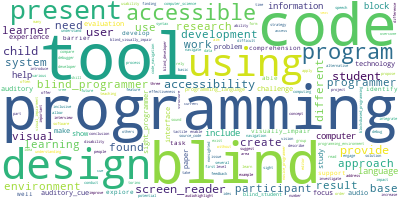

In [12]:
# import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(documents.values))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

# 7. Create Document-Term Matrix
This is the first step towards topic modeling. We need to represent each and every term and document as a vector.We will use sklearn's TfidfVectorizer to create a document-term matrix using only 1000 terms (words) from our corpus.

In [0]:
# set variables
no_terms = 1000

# NMF uses tf-idf Vectorizer
# initialise the tf-idf vectorizer with the English stop words
nmf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_terms, stop_words='english')
# fit and transform the text
nmf_matrix = nmf_vectorizer.fit_transform(documents)
# get features
nmf_feature_names = nmf_vectorizer.get_feature_names()

# LDA can only use raw term counts because it is a probabilistic graphical model
# initialise the count vectorizer with the English stop words
lda_vectorizer = CountVectorizer(max_df=0.5, min_df=2, max_features=no_terms, stop_words='english')
# fit and transform the text
lda_matrix = lda_vectorizer.fit_transform(documents)
# get features
lda_feature_names = lda_vectorizer.get_feature_names()

# LSA uses tf-idf also
# initialise the tf-idf vectorizer with the English stop words
lsa_vectorizer = TfidfVectorizer(max_df = 0.5, max_features= no_terms, stop_words='english', smooth_idf=True)
# fit and transform the text
lsa_matrix = lsa_vectorizer.fit_transform(documents)
# get features
lsa_feature_names = lsa_vectorizer.get_feature_names()


We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors) using the LDA model. As a check, these words should also occur in the word cloud.

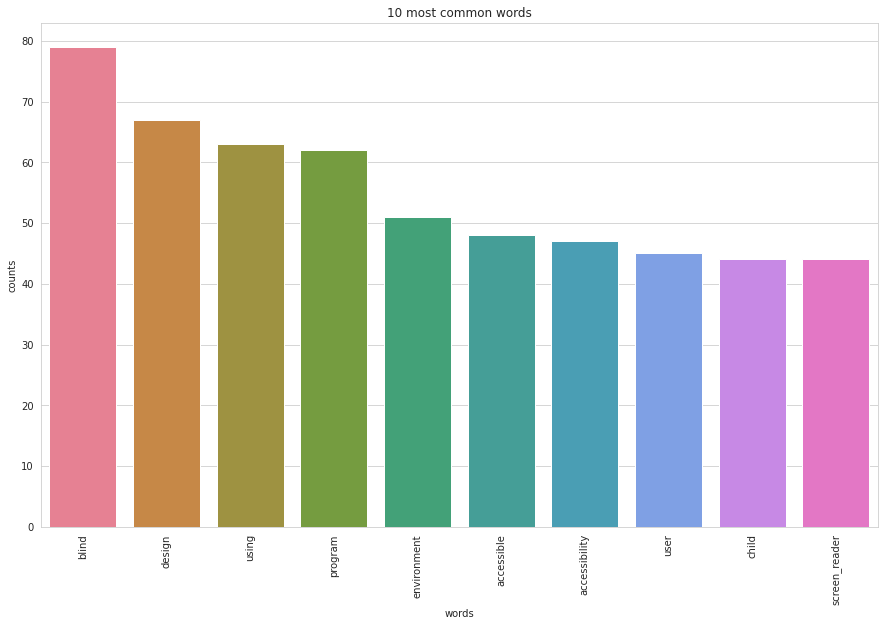

In [16]:
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


# visualise the 10 most common words
plot_10_most_common_words(lda_matrix, lda_vectorizer)

# 8. Apply Topic Model
We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn's LatentDirichletAllocation, to perform the task of matrix decomposition for our LDA Model,  TruncatedSVD for LSA, and  sklearn's NMF to perform the task of matrix decomposition for NMF. The number of topics can be specified by using the n_components parameter.

In [0]:
# set variables
no_topics = 10
no_top_words = 10

# custom function for displaying topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    print("Model %s:" % model_name)
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    dict = pd.DataFrame(word_dict);
    dict.to_csv('%s.csv' % model_name)
    return dict

# run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(nmf_matrix)

# run LDA
lda_model = LatentDirichletAllocation(n_components= no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(lda_matrix)

# run LSA 
lsa_model = TruncatedSVD(n_components=no_topics, algorithm='randomized', n_iter=100, random_state=122).fit(lsa_matrix)


# 9. Display topics and top words

Use display function to show the 10 topics generated by each model and their top words.

In [0]:
# display LDA topics and top words
display_topic(lda_model, lda_feature_names, no_topics, no_top_words, 'LDA_Model')

In [0]:
# display LDA topics and top words
display_topic(lsa_model, lsa_feature_names, no_topics, no_top_words, 'LSA_Model')

In [0]:
# display LDA topics and top words
display_topic(nmf_model, nmf_feature_names, no_topics, no_top_words, 'NMF_Model')


# 10. Classify papers under topics

Using the 10 topics generated by each of our models, we categorize each paper in our corpus under one of the 10 topics.

In [0]:
# use each model to assign topic to papers in corpus
lda_topic_values = lda_model.transform(lda_matrix)
nmf_topic_values = nmf_model.transform(nmf_matrix)
lsa_topic_values = lsa_model.transform(lsa_matrix)

In [0]:
dataset['LDA Topic'] = lda_topic_values.argmax(axis=1)
dataset['LSA Topic'] = lsa_topic_values.argmax(axis=1)
dataset['NMF Topic'] = nmf_topic_values.argmax(axis=1)
dataset.to_csv('results.csv')
dataset.head(50)